In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from os.path import join, splitext
from os import listdir

In [2]:
data_path = '/home/phuijse/Data/OGLE_trainingDB/'
sub_class = 'RRL/RRab'

In [7]:
lc_list = [splitext(file)[0] for file in sorted(listdir(join(data_path, sub_class))) if splitext(file)[1] == '.dat']

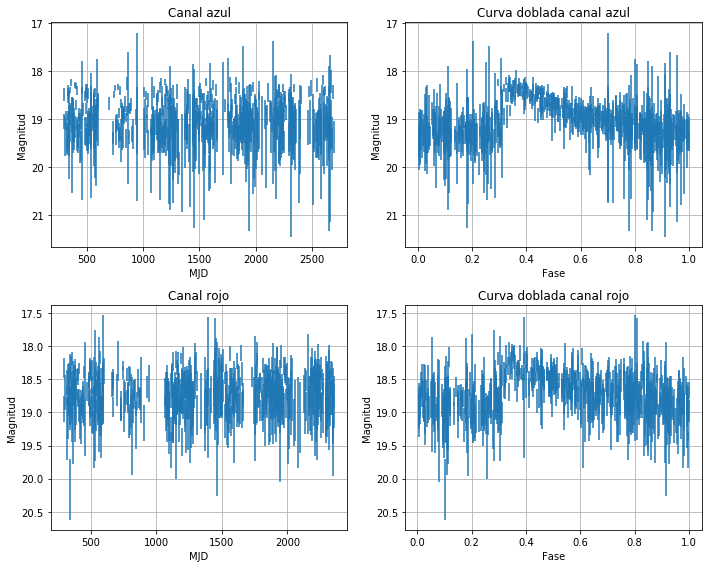

In [10]:
lc_index = 0
data = np.loadtxt(join(data_path, sub_class, lc_list[lc_index]+'.time'))
period = np.loadtxt(join(data_path, sub_class, lc_list[lc_index]+'.dat'))
mjd, mag_r, err_r, mag_b, err_b = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]
"""
mjd_b = mjd
mjd_r = mjd
"""
mjd_b = mjd[err_b < 9.999]
mjd_r = mjd[err_r < 9.999]
mag_b = mag_b[err_b < 9.999]
mag_r = mag_r[err_r < 9.999]
err_b = err_b[err_b < 9.999]
err_r = err_r[err_r < 9.999]

mask = err_b < np.mean(err_b) + 3*np.std(err_b)
mjd_b = mjd_b[mask]
mag_b = mag_b[mask]
err_b = err_b[mask]
mask = err_r < np.mean(err_r) + 3*np.std(err_r)
mjd_r = mjd_r[mask]
mag_r = mag_r[mask]
err_r = err_r[mask]

fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(2, 2, 1)
ax.errorbar(mjd_b, mag_b, err_b, fmt='none')
ax.invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Magnitud')
plt.title('Canal azul')
plt.grid()

ax = fig.add_subplot(2, 2, 3)
ax.errorbar(mjd_r, mag_r, err_r, fmt='none')
ax.invert_yaxis()
plt.title('Canal rojo')
plt.xlabel('MJD')
plt.ylabel('Magnitud')
plt.grid()

ax = fig.add_subplot(2, 2, 2)
ax.errorbar(np.mod(mjd_b, period)/period, mag_b, err_b, fmt='none')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada canal azul')
plt.grid()

ax = fig.add_subplot(2, 2, 4)
ax.errorbar(np.mod(mjd_r, period)/period, mag_r, err_r, fmt='none')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada canal rojo')
plt.grid()
plt.tight_layout()


In [5]:
def smooth(x, window_len=11, window='hanning'):
    if window_len < 3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y    

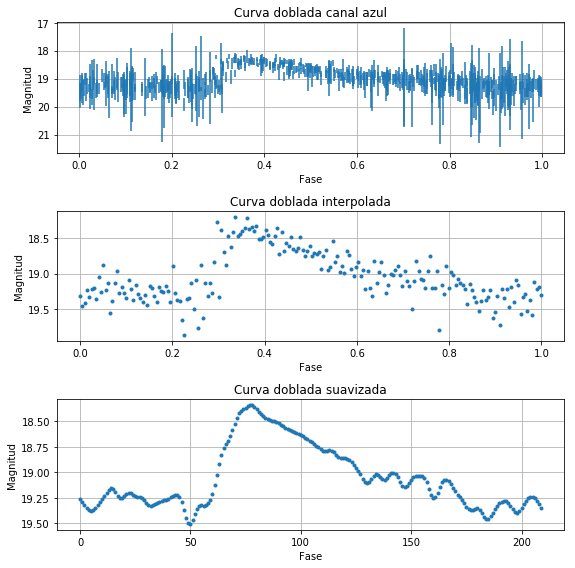

In [11]:
#np.interp()

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(3, 1, 1)
ax.errorbar(np.mod(mjd_b, period)/period, mag_b, err_b, fmt='none')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada canal azul')
plt.grid()
plt.tight_layout()

phi = np.mod(mjd_b, period)/period
I = np.argsort(phi)
phi_rs = np.linspace(0, 1, num=200)
mag_b_rs = np.interp(phi_rs, phi[I], mag_b[I])

ax = fig.add_subplot(3, 1, 2)
ax.plot(phi_rs, mag_b_rs, '.')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada interpolada')
plt.grid()

ax = fig.add_subplot(3, 1, 3)
ax.plot(smooth(mag_b_rs, window_len=11, window='hanning'), '.')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada suavizada')
plt.grid()
plt.tight_layout()



In [11]:
import GPy

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPHeteroscedasticRegression(phi[:, np.newaxis], mag_b[:, np.newaxis], kernel)
m['.*het_Gauss.variance'] = err_b[:, np.newaxis]**2 
m.het_Gauss.variance.fix() 
#m.het_Gauss.period.fix() 
m.optimize()

m.optimize(messages=True)
m.optimize_restarts(num_restarts = 5)
mu, var = m._raw_predict(phi_rs[:, np.newaxis])



Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s35  0002   2.599784e+01   8.244584e-14 
Runtime:     00s35
Optimization status: Converged

Optimization restart 1/5, f = 25.997836088461952
Optimization restart 2/5, f = 25.99783608771861
Optimization restart 3/5, f = 25.997836089282316
Optimization restart 4/5, f = 25.997836092060084
Optimization restart 5/5, f = 25.997836087896587


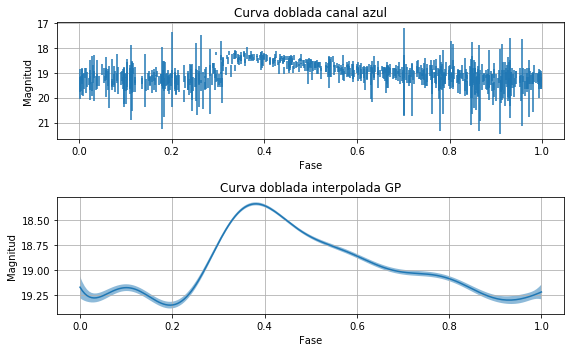

In [12]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(2, 1, 1)
ax.errorbar(np.mod(mjd_b, period)/period, mag_b, err_b, fmt='none')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada canal azul')
plt.grid()
plt.tight_layout()


ax = fig.add_subplot(2, 1, 2)
ax.plot(phi_rs, mu, '-')
ax.fill_between(phi_rs, mu[:,0]-np.sqrt(var[:,0]), mu[:,0]+np.sqrt(var[:,0]), alpha=0.5)
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada interpolada GP')
plt.grid()

plt.tight_layout()